In [1]:
import pandas as pd
import numpy as np
import scipy
import sys
from packaging import version
from sklearn.linear_model import Ridge

def ridge_regression(adata, batch_key, confounder_key=[], chunksize=1e8, copy=False, **kwargs):
	'''
	Perform ridge regression on scaled expression data, accepting both technical and 
	biological categorical variables. The effect of the technical variables is removed 
	while the effect of the biological variables is retained. This is a preprocessing 
	step that can aid BBKNN integration `(Park, 2020) <https://science.sciencemag.org/content/367/6480/eaay3224.abstract>`_.
	
	Alters the object's ``.X`` to be the regression residuals, and creates ``.layers['X_explained']`` 
	with the expression explained by the technical effect.
	
	Input
	-----
	adata : ``AnnData``
		Needs scaled data in ``.X``.
	batch_key : ``list``
		A list of categorical ``.obs`` columns to regress out as technical effects.
	confounder_key : ``list``, optional (default: ``[]``)
		A list of categorical ``.obs`` columns to retain as biological effects.
	chunksize : ``int``, optional (default: 1e8)
		How many elements of the expression matrix to process at a time. Potentially useful 
		to manage memory use for larger datasets.
	copy : ``bool``, optional (default: ``False``)
		If ``True``, return a copy instead of writing to the supplied adata.
	kwargs
		Any arguments to pass to `Ridge <https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html>`_.
	'''
	start = logg.info('computing ridge regression')
	adata = adata.copy() if copy else adata
	#just in case the arguments are not provided as lists, convert them to such
	#as they need to be lists for downstream application
	if not isinstance(batch_key, list):
		batch_key = [batch_key]
	if not isinstance(confounder_key, list):
		confounder_key = [confounder_key]
	
	#construct a helper representation of the batch and biological variables
	#as a data frame with one row per cell, with columns specifying the various batch/biological categories
	#with values of 1 where the cell is of the category and 0 otherwise (dummy)
	#and subsequently identify which of the data frame columns are batch rather than biology (batch_index)
	#and subset the data frame to just those columns, in np.array form (dm)
	dummy = pd.get_dummies(adata.obs[batch_key+confounder_key],drop_first=False)
	if len(batch_key)>1:
		batch_index = np.logical_or.reduce(np.vstack([dummy.columns.str.startswith(x) for x in batch_key]))
	else:
		batch_index = np.vstack([dummy.columns.str.startswith(x) for x in batch_key])[0]
	dm = np.array(dummy)[:,batch_index]
	
	#compute how many genes at a time will be processed - aiming for chunksize total elements per
	chunkcount = np.ceil(chunksize/adata.shape[0])
	
	#make a Ridge with all the **kwargs passed if need be, and fit_intercept set to False
	#(as the data is centered). create holders for results
	LR = Ridge(fit_intercept=False, **kwargs)
	X_explained = []
	X_remain = []
	#loop over the gene space in chunkcount-sized chunks
	for ind in np.arange(0,adata.shape[1],chunkcount):
		#extract the expression and turn to dense if need be
		X_exp = adata.X[:,np.int(ind):np.int(ind+chunkcount)] # scaled data
		if scipy.sparse.issparse(X_exp):
			X_exp = X_exp.todense()
		#fit the ridge regression model, compute the expression explained by the technical 
		#effect, and the remaining residual
		LR.fit(dummy,X_exp)	
		X_explained.append(dm.dot(LR.coef_[:,batch_index].T))
		X_remain.append(X_exp - X_explained[-1])
	
	#collapse the chunked outputs and store them in the object
	X_explained = np.hstack(X_explained)
	X_remain = np.hstack(X_remain)
	adata.X = X_remain
	adata.layers['X_explained'] = X_explained
	logg.info('	finished', time=start,
		deep=('`.X` now features regression residuals\n'
		'	`.layers[\'X_explained\']` stores the expression explained by the technical effect'))
	return adata if copy else None


In [1]:
import scanpy as sc 

In [2]:
import os
save_dir = '/home/htran/storage/datasets/drug_resistance/rna_results/rnaseq_v6/normalization_evaluation/SA535_cisplatin/'
input_dir = '/home/htran/storage/datasets/drug_resistance/rna_results/rnaseq_v6/normalization_evaluation/SA535_cisplatin/'
if not os.path.exists(save_dir): os.makedirs(save_dir)
datatag = 'SA535'

In [5]:
norm_fn = os.path.join(save_dir,'SA535_norm.csv.gz')
norm_df = pd.read_csv(norm_fn, header=0,compression='gzip')
norm_df.shape


(14708, 20084)

In [64]:
import re
bool(re.search(".gz$", norm_fn))

True

In [4]:
import pandas as pd
meta_fn = os.path.join(save_dir,'SA535_meta_info.csv')
meta_df = pd.read_csv(meta_fn, header=0)
meta_df.shape


(20084, 3)

In [10]:
var = pd.DataFrame(index=norm_df.columns.values)
var.shape

(14708, 0)

In [11]:
meta_df.head(5)

,batch,seurat_clusters,cell_id,Barcode,library_id,sample,clone,treatmentSt,timepoint
0,CHIP0148,6,SA535X4XB02498_AAACCCAGTTGCTCCT-1,AAACCCAGTTGCTCCT-1,SCRNA10X_SA_CHIP0148_001,SA535X4XB02498,J,U,X4
1,CHIP0148,6,SA535X4XB02498_AAACGCTGTCAGCTTA-1,AAACGCTGTCAGCTTA-1,SCRNA10X_SA_CHIP0148_001,SA535X4XB02498,J,U,X4
2,CHIP0148,4,SA535X4XB02498_AAAGAACTCCCAATAG-1,AAAGAACTCCCAATAG-1,SCRNA10X_SA_CHIP0148_001,SA535X4XB02498,Q,U,X4
3,CHIP0148,6,SA535X4XB02498_AAAGTCCGTGCATCTA-1,AAAGTCCGTGCATCTA-1,SCRNA10X_SA_CHIP0148_001,SA535X4XB02498,J,U,X4
4,CHIP0148,5,SA535X4XB02498_AAATGGACAACCACAT-1,AAATGGACAACCACAT-1,SCRNA10X_SA_CHIP0148_001,SA535X4XB02498,Q,U,X4


In [19]:
adata = sc.AnnData(np.asarray(norm_df), obs=meta_df, var=var)
adata

/home/htran/anaconda3/envs/sisyphus/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 5296 × 14708
    obs: 'batch', 'seurat_clusters', 'cell_id', 'Barcode', 'library_id', 'sample', 'clone', 'treatmentSt', 'timepoint'

In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/htran/anaconda3/envs/sisyphus/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/htran/anaconda3/envs/sisyphus/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/htran/anaconda3/envs/sisyphus/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


... storing 'batch' as categorical
... storing 'Barcode' as categorical
... storing 'library_id' as categorical
... storing 'sample' as categorical
... storing 'clone' as categorical
... storing 'treatmentSt' as categorical
... storing 'timepoint' as categorical


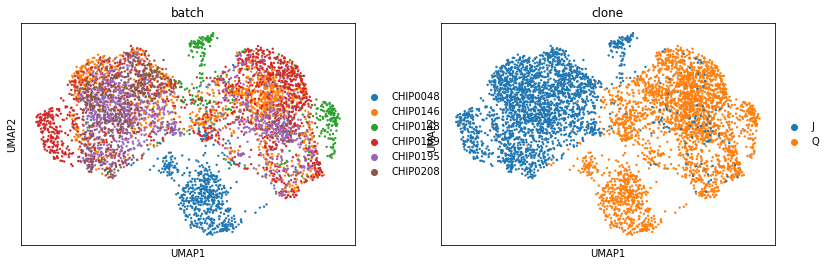

In [21]:
sc.pl.umap(adata, color=['batch','clone'], show=False)

In [22]:
# try:
# 	from scanpy import logging as logg
# except ImportError:
# 	pass
# try:
# 	import anndata
# except ImportError:
# 	pass
# try:
# 	import faiss
# except ImportError:
# 	pass
corrected_adata = ridge_regression(adata, batch_key=['batch'], 
                 confounder_key=['clone'],
                 copy=True)


/home/htran/anaconda3/envs/sisyphus/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [23]:
corrected_adata

AnnData object with n_obs × n_vars = 5296 × 14708
    obs: 'batch', 'seurat_clusters', 'cell_id', 'Barcode', 'library_id', 'sample', 'clone', 'treatmentSt', 'timepoint'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'clone_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_explained'
    obsp: 'distances', 'connectivities'

/home/htran/anaconda3/envs/sisyphus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


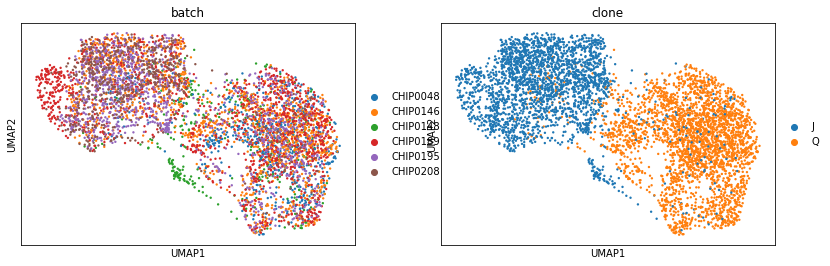

In [24]:
sc.pp.highly_variable_genes(corrected_adata, n_top_genes=3000)
sc.pp.pca(corrected_adata)
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['batch','clone'])

In [25]:
adata_fn = os.path.join(save_dir, 'SA535_untreated_batch_correction.hdf5')
corrected_adata.write(adata_fn)
adata_fn

'/home/htran/storage/datasets/drug_resistance/rna_results/rnaseq_v6/normalization_evaluation/SA535_cisplatin/batch_effect_test/SA535_untreated_batch_correction.hdf5'

In [27]:
corrected_adata.X.shape

(5296, 14708)

In [28]:
?pd.DataFrame

In [38]:
corrected_mtx = pd.DataFrame(corrected_adata.X.T, 
                             index=corrected_adata.var_names.values,
                             columns=corrected_adata.obs['cell_id'].values)
print(corrected_mtx.shape)

(14708, 5296)


In [39]:
output_fn = os.path.join(save_dir, 'SA535_untreated_batch_corrected_mtx.csv')
corrected_mtx.to_csv(output_fn, index=True)

In [71]:
os.path.dirname(output_fn)

'/home/htran/storage/datasets/drug_resistance/rna_results/rnaseq_v6/normalization_evaluation/SA535_cisplatin/batch_effect_test'

In [33]:
corrected_adata.obs_names.values[1]

'1'

In [34]:
adata.obs_names.values[1]

'1'

In [36]:
adata.var_names.__class__

pandas.core.indexes.base.Index

In [37]:
corrected_adata.obs['cell_id'].values[1]

'SA535X4XB02498_AAACGCTGTCAGCTTA-1'

In [40]:
np.max(corrected_adata.X)

7.5267148198884986

In [41]:
print('Before correction: max is: {0}, after correction: max is: {1}'.format(np.max(adata.X),np.max(corrected_adata.X)))

Before correction: max is: 8.133294105529785, after correction: max is: 7.5267148198884986


In [67]:
print('Before correction: max is: {0}, after correction: max is: {1}'.format(np.min(adata.X),np.min(corrected_adata.X)))

Before correction: max is: 0.0, after correction: max is: -1.5798440112887178


In [65]:
# norm_df.shape
cells_use = norm_df.columns.values

(5296, 14708)

In [66]:
np.transpose(norm_df)

,0,1,2,3,4,5,6,7,8,9,...,5286,5287,5288,5289,5290,5291,5292,5293,5294,5295
ENSG00000237491,0.693147,0.693147,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
ENSG00000225880,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.693147,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
ENSG00000230368,0.000000,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
ENSG00000230699,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.693147,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
ENSG00000187634,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.693147,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000276256,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
ENSG00000273748,0.000000,0.000000,0.000000,0.0,0.000000,0.693147,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
ENSG00000278817,0.000000,0.693147,0.693147,0.0,0.693147,1.098612,0.693147,0.0,0.000000,0.0,...,0.0,0.000000,1.098612,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
ENSG00000278384,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.693147,0.0,0.000000,0.0,...,0.0,0.693147,0.000000,0.0,0.000000,0.0,0.000000,0.693147,0.0,0.693147
